# Comprendre l'architecture Transformer avec TolkienGPT 📚

Bienvenue 😀 

Ce notebook n'a qu'un seul objectif. VOUS apprendre quelque chose de nouveau. Plus particulièrement:  

- Comprendre l'architecture Transformer
- Implémenter un Transformer decoder (l'algorithme derrière ChatGPT) avec seulement Pytorch
- Entraîner un Transformer decoder à générer du texte

## About TolkienGPT 🧙‍♂️

TolkienGPT est un modèle de langue qu'on va coder et entraîner dans le but d'imiter l'écriture de mon auteur préféré, J.R.R. Tolkien (Le seigneur des anneaux, Le hobbit, Le silmarillon...). Ce modèle est basé sur l'architecture Transformer introduite dans la publication 📄 [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf). Aussi, la pédagogie 📖 est inspirée du [tutoriel par Andrej Karpathy](https://www.youtube.com/watch?v=kCc8FmEb1nY) de OpenAI 🦾. 

## Les prérequis 🔍

Pour être à l'aise, une compréhension de Python, Pytorch et des concepts de Deep Learning sont nécessaires. Je fais de mon mieux pour vulgariser, mais je ne peux pas faire un vidéo de 3 heures non plus.


Si vous êtes prêts, je vos propose de commencer notre aventure vers les secrets du Transformer Decoder 📜 et la magie de TolkienGPT 🪄!

## Charger les données 🚚

In [37]:
from PyPDF2 import PdfReader
import spacy
nlp = spacy.load("en_core_web_sm")
import re
import os

pdf_path = os.path.join(os.path.expanduser("~"), "Downloads", "Tolkien-J.-The-lord-of-the-rings-HarperCollins-ebooks-2010.pdf")
pdf_reader = PdfReader(pdf_path)
lotr = ""
for i, page in enumerate(pdf_reader.pages):
    if i >= 24 and i < 1163:
        page_str = "".join(page.extract_text())
        nlp_page = nlp(page_str)
        for sentence in nlp_page.sents:
            sentence_text = sentence.text.replace("\n", " ").strip()
            if re.search(r"^[A-Z]", sentence_text):
                # print(sentence_text)
                # print("-----")
                lotr += f"{sentence_text.lower()}\n"
  

replacements = {"-", "  "}
pattern = "|".join(map(re.escape, replacements))
lotr = re.sub(pattern, " ", lotr)       
lotr = re.sub(r"ﬁ", "fi", lotr) 
lotr = re.sub(r"ﬂ", "fl", lotr) 
lotr = re.sub(r"ﬀ", "ff", lotr)
lotr = re.sub(r"æ", "ae", lotr)
lotr = re.sub(r"’", "'", lotr)
with open("lotr.txt", "w") as f:
    f.write(lotr)

## Explorer les données 🕵️‍♂️

In [2]:
print(f"Il y a {len(lotr)} lettres dans le livre")
print(f"Il y a {len(lotr.split())} mots dans le livre")
print(f"Il y a {len(lotr.splitlines())} phrases dans le livre")

Il y a 2191110 lettres dans le livre
Il y a 417877 mots dans le livre
Il y a 26276 phrases dans le livre


In [3]:
print(f"Voici la première phrase du livre:\n {lotr.splitlines()[0]}")

Voici la première phrase du livre:
 prologue  1 concerning hobbits  this book is largely concerned with hobbits, and from its pages a reader may discover much of their character and a little of their  history.


## Tokenizer les données 🏭

Spoiler Alert ⚠️ les ordinateurs ne travaillent jamais directement sur les lettres (ils ne savent pas c'est quoi...). Donc, absolument toutes les applications encode les textes d'une manière ou d'une autre.

En Deep Learning, on les tokenize. C'est-à-dire qu'on donne un ID 🪪 soit à chaque lettre, à chaque bout de mot ou bien directement à chaque mot. 

Ici, on va tokenizer les mots directement (ce n'est pas un tutoriel sur la tokenization), mais les vrais modèles de langue tokenize sur des bouts de mots avec des algorithmes comme [SentencePiece](https://github.com/google/sentencepiece) de Google.

In [38]:
import torch

class lotrWordTokenizer:
    def __init__(self, lotr):
        self.special_chars = re.findall(r"[^a-z\s]", "".join(set(lotr)))
        self.unique_words = [] + self.special_chars
        self.word2idx = {w: i for i, w in enumerate(self.unique_words)}
        self.idx2word = {i: w for i, w in enumerate(self.unique_words)}
        self.pattern = '|'.join(re.escape(special_char) for special_char in self.special_chars) + r"|\s"

    def tokenize_a_sentence(self, sentence):
        matches = {match.start(): match.group() for match in re.finditer(self.pattern, sentence)}
        matches
        running_word = ""
        tokens = []
        for i, char in enumerate(sentence):
            match = matches.get(i)
            if match is not None:
                if running_word != "":
                    running_word = self.process_running_word(running_word, tokens)
                if match != " ":
                    tokens.append(self.word2idx[match])
            else:
                running_word += char

        if running_word != "":
            running_word = self.process_running_word(running_word, tokens)
        return tokens
    
    def process_running_word(self, running_word, tokens):
        if running_word not in self.unique_words:
            self.add_to_lexicon(running_word)
        tokens.append(self.word2idx[running_word])
        return ""

    def add_to_lexicon(self, word):
        self.unique_words.append(word)
        self.word2idx[word] = len(self.unique_words) - 1
        self.idx2word[len(self.unique_words) - 1] = word
        
tokenizer = lotrWordTokenizer(lotr)
tokenized_lotr = []
for sentence in lotr.splitlines():
    tokenized_lotr.extend(tokenizer.tokenize_a_sentence(sentence))
    
    
print(f"Le mot 'gandalf' est le {tokenizer.word2idx['gandalf']}ème token du corpus\n")
random_sentence = " ".join(lotr.splitlines()[9860:9861])
print(f"Voici une phrase aléatoire : \n {random_sentence}")
tokens = tokenizer.tokenize_a_sentence(random_sentence)
print(f"\nVoici les tokens de cette phrase : \n {tokens}")
print(f"\nVoici la phrase reconstruite : \n {' '.join([tokenizer.idx2word[token] for token in tokens])}\n")

tokenized_lotr = torch.tensor(tokenized_lotr)
print(f"Le seigneur des anneaux contient {len(tokenized_lotr)} tokens")

print(f"\nLe seigneur des anneaux contient {len(tokenizer.unique_words)} tokens différents")

Le mot 'gandalf' est le 1270ème token du corpus

Voici une phrase aléatoire : 
 great orcs, who also bore the white hand of isengard: that kind is stronger and more fell than all others.

Voici les tokens de cette phrase : 
 [115, 762, 22, 607, 63, 2303, 67, 769, 178, 55, 6672, 23, 71, 233, 42, 3286, 46, 125, 478, 153, 114, 511, 14]

Voici la phrase reconstruite : 
 great orcs , who also bore the white hand of isengard : that kind is stronger and more fell than all others .

Le seigneur des anneaux contient 489427 tokens

Le seigneur des anneaux contient 13451 tokens différents


In [39]:
lotr_words = ""
for word in tokenizer.unique_words:
    lotr_words += f"{word}\n"
    
with open("lotr_words.txt", "w") as f:
    f.write(lotr_words)

⚠️ **Important** ⚠️

On  un modèle qui écrit du Tolkien. C'est-à-dire qui est capable d'aligner des mots, un après l'autre, comme Tolkien. Donc, il nous faut un modèle qui est capable de prédire le prochain mot à écrire en fonction de ce qu'il a déjà écrit.

Voici ce que je veux dire:

In [7]:
wrote_words = ""
for word in random_sentence.split():
    print(f"TolkienGPT devra apprendre à écrire le mot '{word}' dans un contexte où il a déjà écrit : \n{wrote_words}\n")
    wrote_words += f"{word} "

TolkienGPT devra apprendre à écrire le mot 'great' dans un contexte où il a déjà écrit : 


TolkienGPT devra apprendre à écrire le mot 'orcs,' dans un contexte où il a déjà écrit : 
great 

TolkienGPT devra apprendre à écrire le mot 'who' dans un contexte où il a déjà écrit : 
great orcs, 

TolkienGPT devra apprendre à écrire le mot 'also' dans un contexte où il a déjà écrit : 
great orcs, who 

TolkienGPT devra apprendre à écrire le mot 'bore' dans un contexte où il a déjà écrit : 
great orcs, who also 

TolkienGPT devra apprendre à écrire le mot 'the' dans un contexte où il a déjà écrit : 
great orcs, who also bore 

TolkienGPT devra apprendre à écrire le mot 'white' dans un contexte où il a déjà écrit : 
great orcs, who also bore the 

TolkienGPT devra apprendre à écrire le mot 'hand' dans un contexte où il a déjà écrit : 
great orcs, who also bore the white 

TolkienGPT devra apprendre à écrire le mot 'of' dans un contexte où il a déjà écrit : 
great orcs, who also bore the white h

Maintenant, comment procéder dans un contexte matriciel 🤔?

Je propose d'utiliser la méthode suivante:
- Définir jusqu'à combien de mots en arrière ça vaut la peine de regarder pour écrire le prochain (context_length) 
- Piger aléatoirement un mot dans le text (idx)
- Tronquer les (context_length) mots suivants (idx)
- Garder aussi en mémoire le (context_length + 1)e mot après (idx).
- Apprendre au modèle à prédire chacunes des combinaisons comprises dans l'exemple d'en haut ⬆️:
    - Le (idx + 1)e mot est celui qui devrait suivre le (idx)e mot
    - Le (idx + 2)e mot est celui qui devrait suivre les (idx)e et (idx + 1)e mot
    - ...
    - Le (idx + context_length + 1)e mot est celui qui devrait suivre tous les mots du contexte

Bref, ont initialise deux matrices. L'une contient le contexte et l'autre contient les mots à écrire. Soit:  

In [11]:
context_length = 5
idx = 12346
inputs = [tokenizer.idx2word[tokenized_lotr[i].item()] for i in range(idx, idx + context_length)]
print(f"Voici la matrice des inputs : \n {inputs}")

labels = [tokenizer.idx2word[tokenized_lotr[i].item()] for i in range(idx + 1, idx + context_length + 1)]
print(f"Voici la matrice des labels : \n {labels}")

Voici la matrice des inputs : 
 ['all', 'that', 'was', 'necessary', ')']
Voici la matrice des labels : 
 ['that', 'was', 'necessary', ')', ',']


On créer un [Dataset Pytorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) pour pouvoir facilement loader les phrases ainsi que le prochain mot à prédire.

⚠️ **Important** ⚠️

Les batches sont traitées de manière **indépendantes**. Elles sont utiles parce que le GPU peut les traitées en parrallèle (elles accélère l'entrainement). 

In [24]:
from torch.utils.data import Dataset

class LotrDataset(Dataset):
    def __init__(self, data, context_length, length):
        self.data = data
        self.context_length = context_length
        self.length = length
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, batch_idx):
        input_tensor = torch.stack([self.data[idx:idx + self.context_length] for idx in batch_idx])
        labels = torch.stack([self.data[idx+1:idx + self.context_length+1] for idx in batch_idx])
        return input_tensor, labels

In [12]:
context_length = 32
dataset = LotrDataset(tokenized_lotr, context_length, 1)
batch = dataset[torch.tensor([1, 1234, 12345])]
batch[0].shape, batch[1].shape 

(torch.Size([3, 32]), torch.Size([3, 32]))

## Construire TolkienGPT 🏗️

**Le mécansime d'attention**

En théorie: [Blogue sur le mécansime d'attention](https://www.syntell.com/blogue/nlp-3e-partie-chatgpt/)

En pratique: [Implémentation Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html)

Travaillons ensemble pour comprendre what's going on 🕵️‍♂️

In [25]:
import torch.nn as nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Comment masquer l'attention via calculs matriciels 🤔? 

In [39]:
embedding_table = nn.Embedding(len(tokenizer.unique_words), 4)
x = embedding_table(torch.tensor([tokenizer.word2idx[x] for x in ["gandalf", "the", "grey", "is"]]))
x

tensor([[-1.5666,  1.1510, -0.8756,  1.1321],
        [ 1.0021, -0.1516, -1.4235, -1.5469],
        [ 0.1155, -0.0129,  0.6754,  0.4297],
        [-1.6479, -0.2052,  0.1547, -0.4327]], grad_fn=<EmbeddingBackward0>)

In [64]:
mask = torch.tril(torch.ones((4, 4)))
mask /= torch.sum(mask, dim=1, keepdim=True)
mask

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500]])

In [62]:
y = mask @ x
y

tensor([[-1.5666,  1.1510, -0.8756,  1.1321],
        [-0.2822,  0.4997, -1.1496, -0.2074],
        [-0.1497,  0.3289, -0.5412,  0.0050],
        [-0.5242,  0.1954, -0.3673, -0.1044]], grad_fn=<MmBackward0>)

In [73]:
attn_bias = torch.zeros((4, 4))
mas = torch.tril(torch.ones((4, 4)))
attn_bias.masked_fill_(mas == 0, float("-inf"))
# Communication entre les mots
# attn_bias = torch.softmax(attn_bias, dim=1)
attn_bias

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

Comment masquer les embeddings font pour se parler 🤔? 

- Query = Voici ce que je cherche comme information
- Key = Voici ce que je peux te donner comme information (marketing)
- value = Voici l'information que je te donne réellement

In [78]:
communication = nn.Linear(4, 4*3)
key, query, value = communication(x).chunk(3, dim=-1)
attn_scores = query @ key.transpose(-1, -2) / math.sqrt(query.size(-1))
attn_scores += attn_bias
attn_scores = torch.softmax(attn_scores, dim=-1)
attn_scores = attn_scores @ value
attn_scores.shape

torch.Size([4, 4])

In [26]:
def scaled_dot_product_attention(key, query, value):
    B,_, T, E = key.size()
    attn_bias = torch.zeros((T, T), device=key.device)
    mask = torch.tril(torch.ones((T, T), device=key.device))
    attn_bias.masked_fill_(mask.logical_not(), float("-inf"))
    attn_scores = query @ key.transpose(-1, -2) / math.sqrt(query.size(-1))
    attn_scores += attn_bias
    attn_scores = torch.softmax(attn_scores, dim=-1)
    attn_scores = attn_scores @ value
    return attn_scores
    

In [27]:
class MultiHeadAttention(nn.Module):
    def __init__(self, nb_heads, embedding_size, dropout) -> None:
        super().__init__()
        self.communication = nn.Linear(embedding_size, embedding_size*3, bias=False)
        self.nb_heads = nb_heads
        self.projection = nn.Linear(embedding_size, embedding_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, T, E = x.shape
        key, query, value = self.communication(x).chunk(3, dim=-1)
        key = key.view(B, T, self.nb_heads, E // self.nb_heads).transpose(1, 2) # shape: (batch size, nb heads, sequence length , embedding size per head)
        query = query.view(B, T, self.nb_heads, E // self.nb_heads).transpose(1, 2)
        value = value.view(B, T, self.nb_heads, E // self.nb_heads).transpose(1, 2)
        attn_scores = scaled_dot_product_attention(key, query, value)
        return self.dropout(self.projection(attn_scores.transpose(1, 2).contiguous().view(B, T, E)))
    
class MLP(nn.Module):
    def __init__(self, embedding_size, dropout) -> None:
        super().__init__()
        self.fc1 = nn.Linear(embedding_size, embedding_size)
        self.fc2 = nn.Linear(embedding_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.dropout(self.fc2(F.gelu(self.fc1(x))))
    
class TransformerBlock(nn.Module):
    def __init__(self, nb_heads, embedding_size) -> None:
        super().__init__()
        self.multi_head_attention = MultiHeadAttention(nb_heads, embedding_size, 0.2)
        self.layer_norm1 = nn.LayerNorm(embedding_size)
        self.mlp = MLP(embedding_size, 0.2)
        self.layer_norm2 = nn.LayerNorm(embedding_size)
        
    def forward(self, x):
        x = x + self.multi_head_attention(self.layer_norm1(x))
        x = x + self.mlp(self.layer_norm2(x))
        return x
        

**L'architecture Transformer**

Implémentation selon le paper [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf)

In [28]:
class TolkienGPT(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim, context_length, nb_blocks=6, nb_heads=8
    ):
        super().__init__()
        self.embedding_table = nn.Embedding(vocab_size, embedding_dim)
        self.positional_embeddings = nn.Embedding(context_length, embedding_dim)
        self.blocks = nn.ModuleList(
            [TransformerBlock(nb_heads, embedding_dim) for _ in range(nb_blocks)]
        )
        self.ln = nn.LayerNorm(embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        self.dropout = nn.Dropout(0.2)
        self.vocab_size = vocab_size
        self.context_length = context_length
        self.nb_blocks = nb_blocks
        self.loss_function = nn.CrossEntropyLoss()
        self.apply(self._init_weights)

    def forward(self, x, targets=None):
        B, T = x.shape
        embeddings = self.embedding_table(x) + self.positional_embeddings(
            torch.arange(T, device=x.device)
        )
        E = embeddings.shape[-1]

        x = self.dropout(embeddings)
        for block in self.blocks:
            x = block(x)

        logits = self.linear(self.ln(x))

        logits = logits.view(B * T, self.vocab_size)  # Concaténer les batchs
        if targets is not None:
            targets = targets.view(B * T)
            loss = self.loss_function(logits, targets)
        else:
            loss = None
        return logits.view(B, T, self.vocab_size), loss

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(
                module.weight, mean=0.0, std=0.02 / math.sqrt(2 * self.nb_blocks)
            )
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def generate(self, idx, length):
        with torch.no_grad():
            for _ in range(length):
                # On prend les derniers context_length embeddings comme contexte d'inférence
                context = idx[:, -self.context_length :]
                x_emb, _ = self.forward(context, None)

                # On utilise les derniers logits pour obtenir notre distribution de probabilité pour le prochain mot
                x_emb = x_emb[:, -1, :] / 0.5
                normalized_x_emb = F.softmax(x_emb, dim=-1)

                # On pige un mot suivant cette distribution de probabilité
                next_idx = torch.multinomial(normalized_x_emb, num_samples=1)
                idx = torch.cat([idx, next_idx], dim=-1)
            return idx

## Entraîner TolkienGPT 🚀

In [35]:
context_length = 64
batch_size = 128
embeddind_dim = 768
nb_heads = 16
nb_blocks = 16
model = TolkienGPT(len(tokenizer.unique_words), embeddind_dim, context_length, nb_blocks=nb_blocks, nb_heads=nb_heads)

In [30]:
print(f"Le modèle a {sum(p.numel() for p in model.parameters() if p.requires_grad)} paramètres")

Le modèle a 77421707 paramètres


In [31]:
train_val_split_idx = int(len(tokenized_lotr) * 0.8)
dataset = LotrDataset(torch.tensor(tokenized_lotr), context_length, length=1)
random_idx = torch.randint(low=0, high=train_val_split_idx-context_length, size=(batch_size,))
x, targets = dataset[random_idx]

/tmp/ipykernel_12889/4194449351.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = LotrDataset(torch.tensor(tokenized_lotr), context_length, length=1)


In [32]:
batch_output = model(x, targets)
print(f"Input size: \n {x.shape} (batch_size, context_length) \n\nOutput size: \n {batch_output[0].shape} (batch_size, context_length, embedding_dim)")
print(f"Théoriquement, une loss initialisée random devrait être de {-math.log(1/batch_output[0].size(-1)):.2f}, la loss est de {batch_output[1]:.2f}.")

Input size: 
 torch.Size([128, 64]) (batch_size, context_length) 

Output size: 
 torch.Size([128, 64, 13451]) (batch_size, context_length, embedding_dim)
Théoriquement, une loss initialisée random devrait être de 9.51, la loss est de 9.51.


In [36]:
from lr_scheduler import TrainingScheduler

train_val_split_idx = int(len(tokenized_lotr) * 0.8)
dataset = LotrDataset(torch.tensor(tokenized_lotr), context_length, length=1)

model = model.cuda()
lr0 = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=lr0)
nb_epochs = 10000
warmup_steps = 100
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, nb_epochs - warmup_steps
)
scheduler = TrainingScheduler(
    optimizer=optimizer, warmup_iteration=warmup_steps, lr0=lr0, scheduler=lr_scheduler
)

best_val_loss = torch.inf
for epoch in range(nb_epochs):
    model.train()
    train_loss = 0
    for i in range(len(dataset)):
        random_idx = torch.randint(
            low=0, high=train_val_split_idx - context_length, size=(batch_size,)
        )
        x, targets = dataset[random_idx]
        x, targets = x.cuda(), targets.cuda()
        batch_output = model(x, targets)
        train_loss += batch_output[1].item()
        optimizer.zero_grad()
        batch_output[1].backward()
        optimizer.step()
    train_loss /= len(dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i in range(len(dataset)):
            random_idx = torch.randint(
                low=train_val_split_idx + 1,
                high=len(tokenized_lotr) - context_length,
                size=(batch_size,),
            )
            x, targets = dataset[random_idx]
            x, targets = x.cuda(), targets.cuda()
            batch_output = model(x, targets)
            val_loss += batch_output[1].item()
        val_loss /= len(dataset)
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), "best.pt")
            best_val_loss = val_loss
            print(f"New best model saved with val loss: {best_val_loss:.2f}")
        if epoch % 10 == 0:
            print(
                f"Epoch {epoch} | Train loss: {train_loss:.2f} | Val loss: {val_loss:.2f}"
            )
    scheduler.step(epoch)
print(f"Best val loss: {best_val_loss:.2f}")

/tmp/ipykernel_12889/1252902887.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = LotrDataset(torch.tensor(tokenized_lotr), context_length, length=1)


New best model saved with val loss: 9.51
Epoch 0 | Train loss: 9.51 | Val loss: 9.51
New best model saved with val loss: 9.51
New best model saved with val loss: 9.51
New best model saved with val loss: 9.51
New best model saved with val loss: 9.51
New best model saved with val loss: 9.50
New best model saved with val loss: 9.50
New best model saved with val loss: 9.49
New best model saved with val loss: 9.49
New best model saved with val loss: 9.48
Epoch 10 | Train loss: 9.49 | Val loss: 9.48
New best model saved with val loss: 9.47
New best model saved with val loss: 9.47
New best model saved with val loss: 9.46
New best model saved with val loss: 9.45
New best model saved with val loss: 9.44
New best model saved with val loss: 9.42
New best model saved with val loss: 9.41
New best model saved with val loss: 9.40
New best model saved with val loss: 9.39
New best model saved with val loss: 9.37
Epoch 20 | Train loss: 9.42 | Val loss: 9.37
New best model saved with val loss: 9.36
New b

## Générer du Tolkien avec TolkienGPT ✍️

In [20]:
model = TolkienGPT(len(tokenizer.unique_words), embeddind_dim, context_length, nb_blocks=nb_blocks, nb_heads=nb_heads)
model.load_state_dict(torch.load("best.pt"))
model.cuda()
model.eval()
phrase = "the hobbits stood now on the brink of a tall cliff, bare and bleak, its feet wrapped in mist; and behind them rose the broken highlands crowned with drifting cloud. a chill wind blew from the east."
tokenized_phrase = torch.tensor(tokenizer.tokenize_a_sentence(phrase)).view(1, -1)
output = model.generate(tokenized_phrase.cuda(), length=128)
print(f"Voici la phrase générée : \n {' '.join([tokenizer.idx2word[token] for token in output.tolist()[0]])}")

Voici la phrase générée : 
 the hobbits stood now on the brink of a tall cliff , bare and bleak , its feet wrapped in mist ; and behind them rose the broken highlands crowned with drifting cloud . a chill wind blew from the east . there was a dark gate , and the water was still , and the wind was still in the mountains . the moon was still silent , but it was heavy , and the black sun was not very further . the trees were still in the wind , and they were gone . the mountains were clad in the gate , and the mountains were great and level . the sun was now in the path , and the sun was descended into the stream . the dark shadow was filled with the east . the moon was still and the light of the river , and the great river grew in the forest . the hobbits had found that the great river was still in the


## Bonus 🤩

In [15]:
import time

tokenized_phrases = torch.stack([tokenized_phrase.view(-1) for _ in range(1)])

times = []
for i in range(100):
    start = time.perf_counter()
    output = model(tokenized_phrases.cuda(), None)
    if i == 0:
        print(f"Output size: \n {output[0].shape} (batch_size, context_length, embedding_dim)")
    end = time.perf_counter()
    times.append(end-start)
    
times = torch.tensor(times)
    
print(f"Temps moyen de génération d'une phrase : {times[1:].mean():.4f} secondes")

Output size: 
 torch.Size([1, 1, 13451]) (batch_size, context_length, embedding_dim)
Temps moyen de génération d'une phrase : 0.0070 secondes


In [216]:
labels = ["gandalf", "aragorn", "frodo", "sam", "sauron", "bilbo", "legolas", "gimli", "saruman", "pippin", "merry", "boromir", "faramir", "gollum", "elrond", "galadriel", "denethor", "eomer", "eowyn"]
# labels = ["gandalf", "sauron"]
tokenized_labels = torch.tensor(tokenizer.tokenize_a_sentence(" ".join(labels))).view(1, -1)
model = model.cpu()
embeddings = model.embedding_table(tokenized_labels)
embeddings.shape

torch.Size([1, 19, 768])

In [221]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings.squeeze().detach().numpy())
n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)


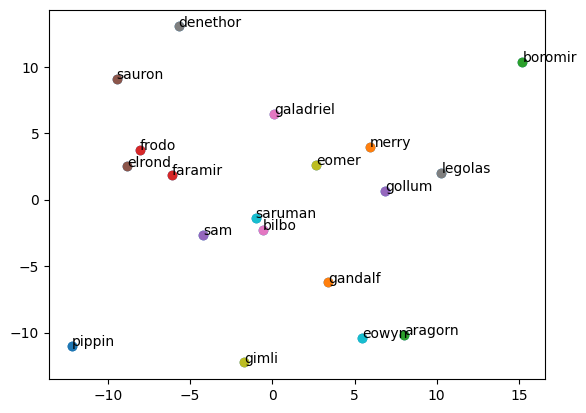

In [222]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])
for i, label in enumerate(labels):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], label=label)
    plt.text(X_pca[i, 0], X_pca[i, 1], label)

plt.show()